<a href="https://colab.research.google.com/github/yydevelop/study/blob/main/01_automl_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoMLによる「回帰」
ライブラリPyCaretを使い、AutoMLによる「回帰」の機械学習を実装します。  
ダイヤモンドの様々な観測データから、その価格を予測します。  

## PyCaretのインストール
AutoMLをサポートするライブラリ、PyCaretをバージョンを指定してインストールします。

In [21]:
!pip install pycaret==2.3.1

## Google Colabの設定
Google Colab環境でPyCaretのインタラクティブな要素を表示するためには、以下のコードを実行する必要があります。

In [22]:
from pycaret.utils import enable_colab

enable_colab()

Colab mode enabled.


## データセットの読み込み
今回は「Sarah Gets a Diamond」というデータセットを使います。  
データセットには6000レコードが含まれています。  
各カラムの簡単な説明は以下の通りです。

* ID: 各ダイヤを識別するためのID
* Carat Weight: ダイヤの重量
* Cut: ダイヤモンドのカットを望ましい順に並べたもの（Signature-Ideal、Ideal、Very Good、Good、Fair)
* Color: ダイヤモンドの色（D、E、Fは無色、G、H、Iは無色に近い）
* Clarity: ダイヤモンドのクラリティ（F - Flawless、IF - Internally Flawless、VVS1またはVVS2 - Very, Very Slightly Included、VS1またはVS2 - Very Slightly Included、SI1 - Slightly Included）
* Polish: ダイヤモンドの研磨状態（ID - Ideal、EX - Excellent、VG - Very Good、G - Good）
* Symmetry: ダイヤモンドの対称性（ID - 理想的、EX - 優れている、VG - 非常に良い、G - 良い）
* Report: 「 AGSL」または「GIA」のいずれかで、ダイヤの品質を報告した鑑定機関を示す
* Price: ダイヤモンドの評価額（米ドル）

https://www.kaggle.com/c/abafall2020/data

In [23]:
from pycaret.datasets import get_data

dataset = get_data("diamond")  # データの取得
dataset.shape  # データの形状

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1.10,Ideal,H,SI1,VG,EX,GIA,5169
1,0.83,Ideal,H,VS1,ID,ID,AGSL,3470
2,0.85,Ideal,H,SI1,EX,EX,GIA,3183
3,0.91,Ideal,E,SI1,VG,VG,GIA,4370
4,0.83,Ideal,G,SI1,EX,EX,GIA,3171


(6000, 8)

訓練済みモデルの検証に用いる「未知のデータ」を訓練データから取り出します。  

In [24]:
data = dataset.sample(frac=0.9, random_state=786)  # 訓練データ
data_unseen = dataset.drop(data.index)  # 未知のデータ

data.reset_index(drop=True, inplace=True)  # インデックスを初期化
data_unseen.reset_index(drop=True, inplace=True)  # インデックスを初期化

print("訓練データの形状: " + str(data.shape))
print("未知のデータの形状: " + str(data_unseen.shape))

訓練データの形状: (5400, 8)
未知のデータの形状: (600, 8)


## 環境の設定
PyCaretの環境を設定します。  
setup関数はPyCaretの環境を初期化しますが、PyCaretの他の関数を実行する前に呼び出す必要があります。  

以下のコードを実行すると、setup関数が実行されてすべての特徴のデータ型が自動的に推定されます。  
この際に、必ずしも正しく推論されるとは限らないことにご注意ください。     
データの型に問題が無ければ、空白を入力することで設定を完了することができます。  

In [25]:
from pycaret.regression import setup

clf = setup(data=data, target="Price", session_id=123)  # 環境の初期化

,Description,Value
0,session_id,123
1,Target,Price
2,Original Data,"(5400, 8)"
3,Missing Values,False
4,Numeric Features,1
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(3779, 28)"


## モデルの比較
様々なモデルを比較して、性能を評価します。  
compare_models関数は、ライブラリ内のすべてのモデルを使って訓練を行い、スコアを評価します。  

In [26]:
from pycaret.regression import compare_models

best_model = compare_models()  # 全てのモデルを訓練し、評価する

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,762.0118,2.763999e+06,1612.2410,0.9729,0.0817,0.0607,1.265
rf,Random Forest Regressor,760.6304,2.929683e+06,1663.0148,0.9714,0.0818,0.0597,1.176
lightgbm,Light Gradient Boosting Machine,752.6446,3.056348e+06,1687.9907,0.9711,0.0773,0.0567,0.073
gbr,Gradient Boosting Regressor,920.0795,3.763129e+06,1900.8431,0.9633,0.1024,0.0770,0.260
dt,Decision Tree Regressor,1003.1237,5.305620e+06,2228.7271,0.9476,0.1083,0.0775,0.030
ridge,Ridge Regression,2413.5704,1.412049e+07,3726.1643,0.8621,0.6689,0.2875,0.015
lasso,Lasso Regression,2412.1923,1.424680e+07,3744.2305,0.8608,0.6767,0.2866,0.040
llar,Lasso Least Angle Regression,2355.6152,1.427202e+07,3745.3095,0.8607,0.6391,0.2728,0.018
br,Bayesian Ridge,2415.8031,1.427077e+07,3746.9951,0.8606,0.6696,0.2873,0.019
lr,Linear Regression,2418.7037,1.427937e+07,3748.9580,0.8604,0.6690,0.2879,0.016


わずか1行のコードで、15以上の機械学習モデルを訓練し、評価することができました。  
  
最もスコアの良いモデルの概要を表示します。


In [27]:
print(best_model)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=123, verbose=0, warm_start=False)


## モデルの作成
models関数により、全ての使用可能な機械学習モデルを確認することができます。

In [28]:
from pycaret.regression import models

models()  # 機械学習モデルの一覧

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


create_model関数は、「交差検証」を用いて個別のモデルの訓練と評価を行います。  
デフォルトでは、データを10に分割し10通りのテストデータ/訓練データの組み合わせを試します。     
  
今回は、上記の中で最もシンプルな「線形回帰」のモデルを作成します。  

In [29]:
from pycaret.regression import create_model

lr = create_model("lr")  # 線形回帰のモデルを作成

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2381.9102,1.226271e+07,3501.8152,0.8654,0.4695,0.2593
1,2596.1006,2.321779e+07,4818.4844,0.8221,0.7841,0.2915
2,2440.1509,1.614320e+07,4017.8599,0.8519,0.6548,0.2965
3,2332.3123,1.076285e+07,3280.6780,0.8813,0.6797,0.2744
4,2455.7566,1.018464e+07,3191.3391,0.8730,0.6316,0.3353
5,2495.1772,1.725298e+07,4153.6709,0.8528,0.5594,0.2908
6,2279.1560,1.270736e+07,3564.7388,0.8806,0.6651,0.2645
7,2382.6431,1.146744e+07,3386.3604,0.8550,0.6893,0.2931
8,2380.5115,1.264378e+07,3555.8088,0.8758,0.7549,0.2742
9,2443.3184,1.615095e+07,4018.8245,0.8462,0.8015,0.2992


訓練済みモデルの概要を表示します。  

In [30]:
print(lr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)


各ハイパーパラメータの意味は、scikit-learnの公式ドキュメントに解説があります。  
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

## ハイパーパラメータの調整
create_model関数は、デフォルトのハイパーパラメータを使ってモデルを訓練します。  
ハイパーパラメータを調整するためには、tune_model関数を使用します。  

In [31]:
from pycaret.regression import tune_model

tuned_lr = tune_model(lr)  # ハイパーパラメータの調整

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2380.1072,1.225749e+07,3501.0696,0.8654,0.4712,0.2593
1,2600.1909,2.332671e+07,4829.7734,0.8212,0.5635,0.2916
2,2438.9680,1.613706e+07,4017.0959,0.8520,0.6569,0.2963
3,2327.7229,1.069617e+07,3270.5002,0.8820,0.7797,0.2744
4,2455.6426,1.018458e+07,3191.3281,0.8730,0.6320,0.3353
5,2455.1997,1.682505e+07,4101.8350,0.8564,0.6213,0.2840
6,2277.6663,1.271790e+07,3566.2158,0.8805,0.6736,0.2640
7,2382.6409,1.146744e+07,3386.3604,0.8550,0.6893,0.2931
8,2380.5103,1.264378e+07,3555.8086,0.8758,0.7549,0.2742
9,2445.7600,1.618504e+07,4023.0635,0.8459,0.8371,0.2989


ハイパーパラメータを調整済みの、訓練済みモデルの概要を表示します。  

In [32]:
print(tuned_lr)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=-1, normalize=True)


## モデルを評価する
plot_model関数により、様々な角度からモデルを分析することができます。  
https://pycaret.org/plot-model/

plot_model関数でplotを指定しない場合、残差プロット（Residual Plot）が表示されます。  
残差プロットは横軸に予測値をとり、縦軸に回帰残差をとってプロットしたものです。  
これにより、何らかの規則性や分散の偏りなどの有無を判断することができます。 

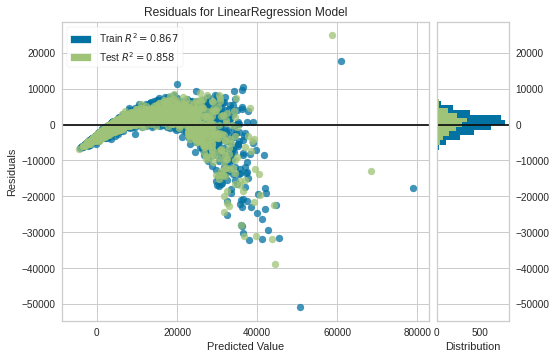

In [33]:
from pycaret.regression import plot_model

plot_model(tuned_lr)

以下のコードは、各特徴量の重要度をプロットします。

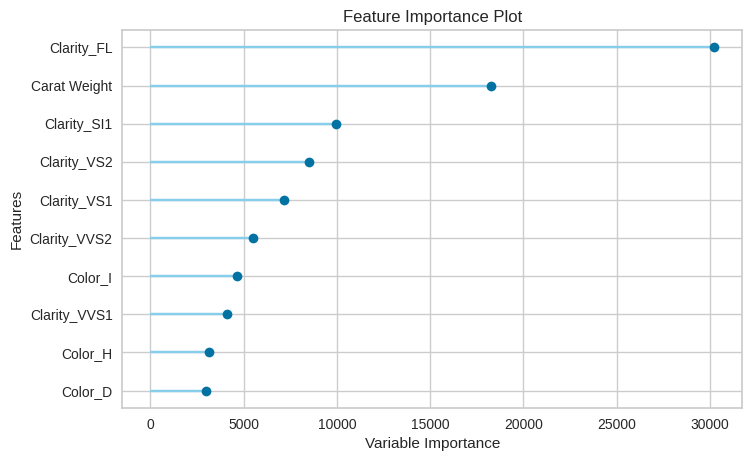

In [34]:
plot_model(tuned_lr, plot="feature")  # 各特徴の重要度をプロット

モデルは、`evaluate_model`関数で評価することもできます。  

In [35]:
from pycaret.regression import evaluate_model

evaluate_model(tuned_lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## デプロイ用のモデルを作成
`finalize_model`関数により全てのデータセットを使ってモデルを訓練し、デプロイ用のモデルを作成します。   

In [36]:
from pycaret.regression import finalize_model

final_lr = finalize_model(tuned_lr)
print(final_lr)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=-1, normalize=True)


`predict_model`関数によりデプロイ用のモデルを評価します。

In [37]:
from pycaret.regression import predict_model

predict_model(final_lr);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2495.129395,15365271.0,3919.855957,0.8599,0.6195,0.2808


`save_model`関数によりモデルを保存することができます。  

In [38]:
from pycaret.regression import save_model

save_model(final_lr, "lr_model")

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='Price',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='...
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='Price')),
                 ('fix_perfect', Remove_100(target='Price')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
            

`load_model`関数により、保存されたモデルを読み込むことができます。

In [39]:
from pycaret.regression import load_model

loaded_lr = load_model("lr_model")

Transformation Pipeline and Model Successfully Loaded


## 未知のデータで予測する
デプロイ用のモデルを使い、「未知のデータ」で価格の予測を行います。  

In [40]:
unseen_pred = predict_model(loaded_lr, data=data_unseen)
unseen_pred.head()

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price,Label
0,1.53,Ideal,E,SI1,ID,ID,AGSL,12791,15271.388672
1,1.50,Fair,F,SI1,VG,VG,GIA,10450,13842.484375
2,1.01,Good,E,SI1,G,G,GIA,5161,5130.611328
3,2.51,Very Good,G,VS2,VG,VG,GIA,34361,32237.570312
4,1.01,Good,I,SI1,VG,VG,GIA,4238,-440.745117
